## Introduction

Working with these files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by your CNN.

Fortunately, I participated in the LUNA16 competition as part of a university course on computer aided diagnosis, so I have some experience working with these files. At this moment we top the leaderboard there :)

**This tutorial aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method.**

What we will cover:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.


---

Before we start, let's import some packages and determine the available patients.

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/mnt/data/stage1/'
patient_ids = os.listdir(INPUT_FOLDER)
patient_ids.sort()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Loading the files
Dicom is the de-facto file standard in medical imaging. This is my first time working with it, but it seems to be fairly straight-forward.  These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). 

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.

Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset is one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata.

In [15]:
# Load the scans in given folder path
def load_scans(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # slices.sort(key = lambda x: int(x.InstanceNumber))
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [3]:
# def get_pixels_hu(scans):
#     image = np.stack([s.pixel_array for s in scans])
#     # Convert to int16 (from sometimes int16), 
#     # should be possible as values should always be low enough (<32k)
#     image = image.astype(np.int16)

#     # Set outside-of-scan pixels to 0
#     # The intercept is usually -1024, so air is approximately 0
#     image[image == -2000] = 0
    
#     # Convert to Hounsfield units (HU)
#     intercept = scans[0].RescaleIntercept
#     slope = scans[0].RescaleSlope
    
#     if slope != 1:
#         image = slope * image.astype(np.float64)
#         image = image.astype(np.int16)
        
#     image += np.int16(intercept)
    
#     return np.array(image, dtype=np.int16)

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array.astype(np.float32) * s.RescaleSlope + s.RescaleIntercept for s in scans])
    image = image.astype(np.int16)
   
    return image

Let's take a look at one of the patients.

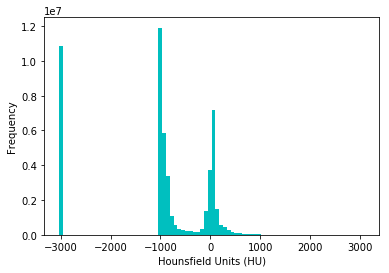

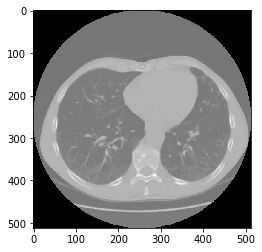

In [16]:
scans = load_scans(INPUT_FOLDER + patient_ids[0])
image = get_pixels_hu(scans)
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image[80], cmap=plt.cm.gray)
plt.show()

Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue. We will use this for lung segmentation in a bit :)


----------

# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [7]:
def resample(image, scans, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scans[0].SliceThickness] + scans[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, order=1)
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [17]:
pix_resampled, spacing = resample(image, scans, [1,1,1])
print("Shape before resampling\t", image.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (195, 512, 512)
Shape after resampling	 (390, 355, 355)


# 3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

Our plot function takes a threshold argument which we can use to plot certain structures, such as all tissue or only the bones. 400 is a good threshold for showing the bones only (see Hounsfield unit table above). Let's do this!

In [9]:
plot_3d(pix_resampled, 400)

KeyboardInterrupt: 

Spooky!

# Lung segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective. 

It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.

The steps:  

* Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
* Do connected components, determine label of air around person, fill this with 1s in the binary image
* Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
* Keep only the largest air pocket (the human body has other pockets of air here and there).

In [84]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    binary_image = np.array(image > -320, dtype=np.int8)
    binary_image = scipy.ndimage.morphology.binary_dilation(binary_image, border_value=0, iterations=2).astype(np.int8)
    # HACK deal with trays
    binary_image[-1,:,0] = 0
    binary_image[-1,:,-1] = 0
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image += 1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [18]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

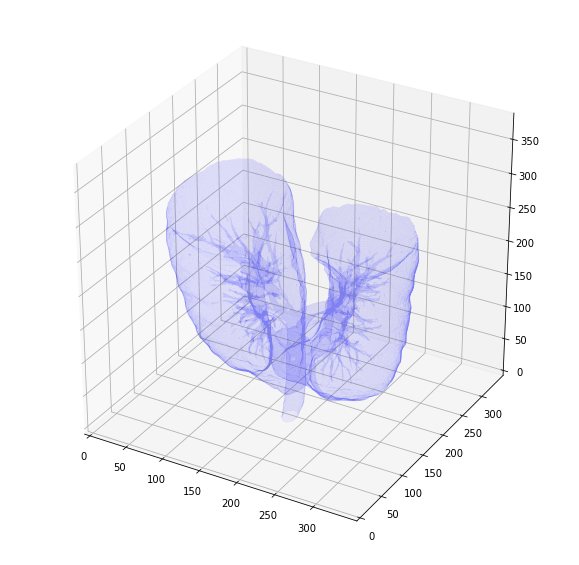

In [33]:
plot_3d(segmented_lungs, 0)

Beautiful! 

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as the nodules are solid), we do not only want to air in the lungs. 

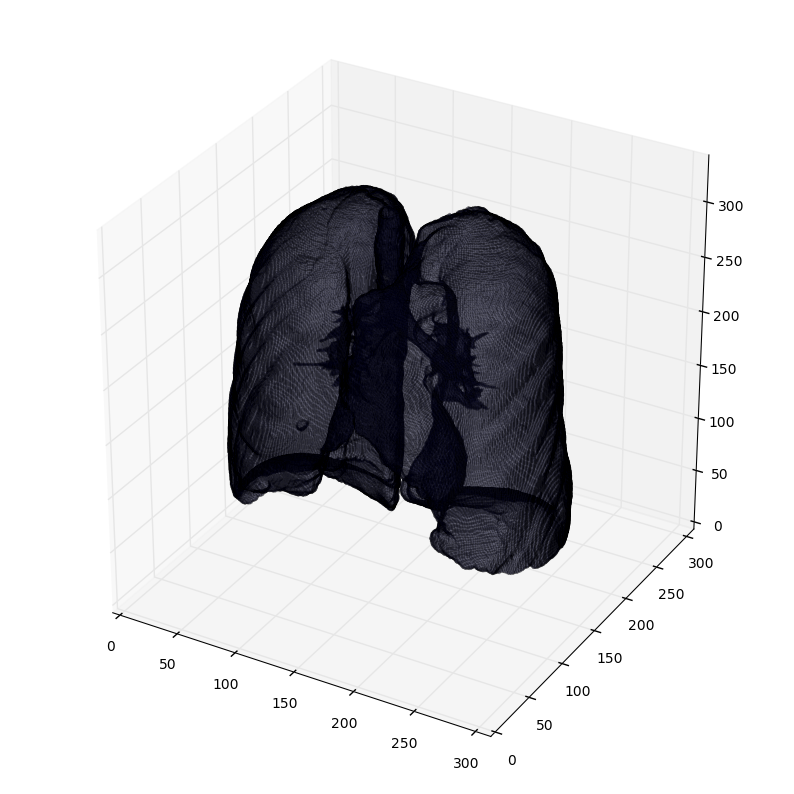

In [12]:
plot_3d(segmented_lungs_fill, 0)

That's better. Let's also visualize the difference between the two.

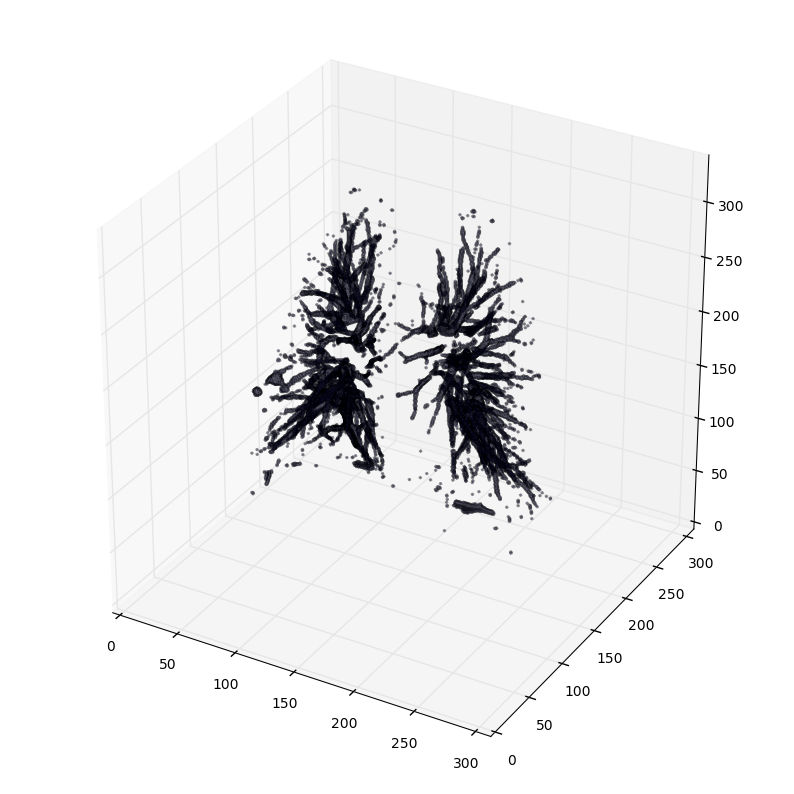

In [13]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

Pretty cool, no? 

Anyway, when you want to use this mask, **remember to first apply a dilation morphological operation** on it (i.e. with a circular kernel).  This expands the mask in all directions. The air + structures in the lung alone will not contain all nodules, in particular it will miss those that are stuck to the side of the lung, where they often appear! So expand the mask a little :)

**This segmentation may fail for some edge cases**. It relies on the fact that the air outside the patient is not connected to the air in the lungs. If the patient has a [tracheostomy](https://en.wikipedia.org/wiki/Tracheotomy), this will not be the case, I do not know whether this is present in the dataset. Also, particulary noisy images (for instance due to a pacemaker in the image below) this method may also fail. Instead, the second largest air pocket in the body will be segmented. You can recognize this by checking the fraction of image that the mask corresponds to, which will be very small for this case. You can then first apply a morphological closing operation with a kernel a few mm in size to close these holes, after which it should work (or more simply, do not use the mask for this image). 

![pacemaker example][1]

# Normalization
Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity.  A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:


  [1]: http://i.imgur.com/po0eX1L.png

In [14]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Zero centering

As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels. 

To determine this mean you simply average all images in the whole dataset.  If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition. 

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [15]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

# What's next? 

With these steps your images are ready for consumption by your CNN or other ML method :). You can do all these steps offline (one time and save the result), and I would advise you to do so and let it run overnight as it may take a long time. 

**Tip:** To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading). If you don't do this yet, your image are int16's, which are smaller than float32s and easier to compress as well.

**If this tutorial helped you at all, please upvote it and leave a comment :)**

In [14]:
patients

['274297dd9a4f66148754944ae2b6731c',
 '2a549c66f24af964de6f25165c55e331',
 '4419818b57ef8b0f8d6d95594adab922',
 '66a94647459dd5a13f4336e1421119c5',
 '72ed4046708e5607eb0a5703905438ee',
 '7daeb8ef7307849c715f7f6f3e2dd88e',
 '7f137d30638a87d151ac7e84eeaf48e8',
 '934f01786c3bdf8eeaf7d8411a3a8f82',
 'd104e584e51830ea51ee60e69186f83b',
 'dc66d11755fd073a59743d0df6b62ee2']

In [24]:
scans[0].PixelSpacing

['0.703125', '0.703125']

In [25]:
scans[0].SliceThickness

'2.5'

In [11]:
import json

OUTPUT_FOLDER = '/mnt/data/processed/'

def process_series(pid):
    print(pid)
    scans = load_scans(INPUT_FOLDER + pid)
    image = get_pixels_hu(scans)
    np.save(OUTPUT_FOLDER + 'original_resolution/' + pid + '.npy', image)

    spacing = [ float(x) for x in ([scans[0].SliceThickness] + scans[0].PixelSpacing) ]
    #print(spacing)

    with open(OUTPUT_FOLDER + 'original_resolution/' + pid + '.info.json', 'w') as f:
        json.dump({'spacing': spacing}, f)

    image_1mm, _ = resample(image, scans, [1,1,1])
    np.save(OUTPUT_FOLDER + '1mm/' + pid + '.npy', image_1mm)

    #     image_iso, _ = resample(image, scans, [spacing[1], spacing[1], spacing[2]])
    #     np.save(OUTPUT_FOLDER + 'iso/' + pid + '.npy', image_iso)

    segmented_lungs_fill = segment_lung_mask(image, True)
    np.save(OUTPUT_FOLDER + 'segmented_lungs/' + pid + '.npy', segmented_lungs_fill)

# pid = patient_ids[0]
# # for pid in patient_ids:
# process_series(pid)

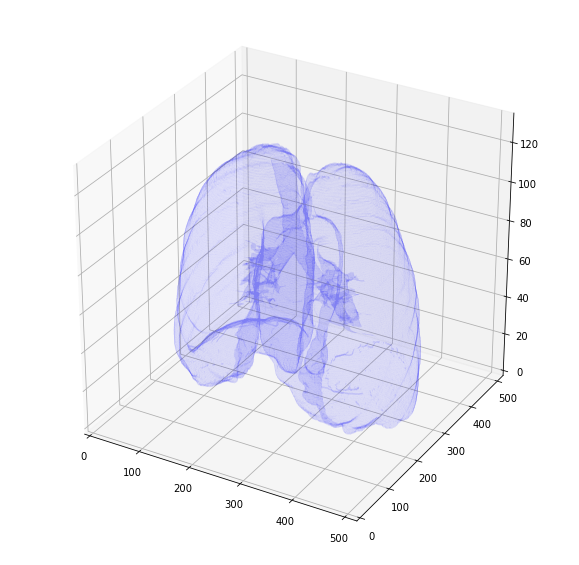

In [39]:
plot_3d(segmented_lungs_fill, 0)

In [51]:
segmented_lungs_fill.dtype

dtype('int8')

In [50]:

image.dtype

dtype('int16')

In [100]:
from multiprocessing import Pool
pool = Pool(processes=32)
#pool.map(process_series, patient_ids)
pool.imap_unordered(process_series, bad_pids)


006b96310a37b36cccb2ab48d10b49a3
028996723faa7840bb57f57e28275e4c


0121c2845f2b7df060945b072b2515d7
08528b8817429d12b7ce2bf444d264f9
16377fe7caf072d882f234dbbff9ef6c
0257df465d9e4150adef13303433ff1e
1748ad43b222be66f3e5ae4bd70c02ac
1bb17a55702a78142cd05cd1063c82c8
186d95f7c17fd666726c10251072d44b
17f5ae9fa49c4e47624f344d29bd03eb
20c73e37fc89e007ae5b242480830860
198d3ff4979a9a89f78ac4b4a0fe0638
1ff6e2a80eb74396e09460c61ae69fb0
1a41350d4bbd74b7e0e28239cefa84c2
1e0f8048728717064645cb758eb89279
1c42a5da837f4122d2c3b59ca9b5f0fb
21b73c938fd7d346ee77a60bd60aaeac
229b8b785f880f61d8dad636c3dc2687
2969c7ad0e550fee1f4a68fcb3bbb9e5
2615d445b6d3865407d1a4422d25058e
1a91ca95390756518700877893ac195b
2895ce2fe73dd62554326c3ab1c3b686
263fa87394ee296e31234364e75d05e2
2a48f50391e22040f28e258a74dcaf95
2fa939efbc3e1c2bc57ba5a98922ff3b
310b403db75226a9a44d9a29c18917b7
2b89691a0744504491ef91d711d94918
2b55d9c3f8e05951c87e90d2361aca6a
31c090cf66ec7bf090801d14d63199b5
31e82ed2c875eae8dfbfd70ac440458a
322bf0acacba9650fa5656b9613c75c8
32cda856b7ec759fd3ebaa363c505e88
33387bea2c

In [12]:
len(patient_ids)

1595

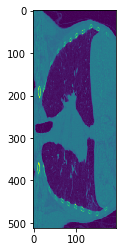

In [20]:
p = image.transpose(2,1,0)
p = p[:,:,::-1]
plt.imshow(p[:,256,:])

In [22]:
import random
import scipy.ndimage.morphology

80bda1afde73204abd74d1ebd2758382


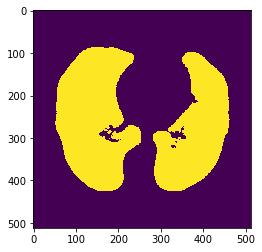

35105d801880bd889bac5ee3771ed38b


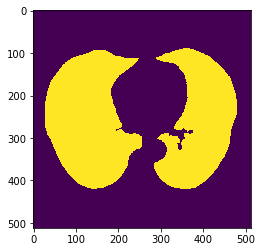

fb5874408966d7c6bebd3d84a5599e20


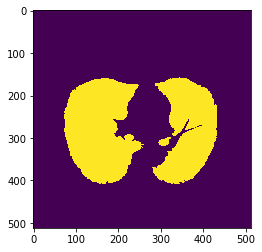

c645eb8b7b7225457e61cf511a8e46e5


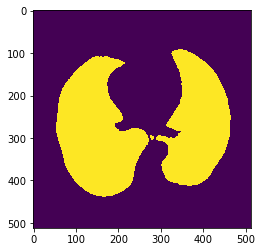

bc848c4d50c2f72fdcc1102475b56525


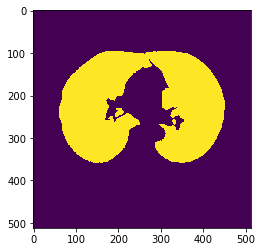

ee88217bee233a3bfc971b450e3d8b85


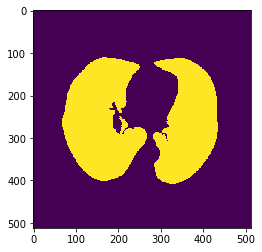

4fcf8b00ea7a99162dc70aba253ba669


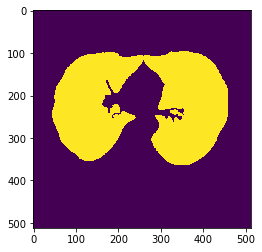

b51f22a84cd2fae1de8bd1eb155933f7


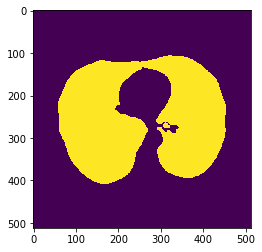

565cdee745ea4e6afc0f7daae81a7963


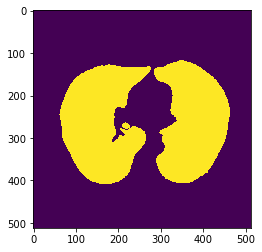

82df9b029653e867e86ce9e86ca7275c


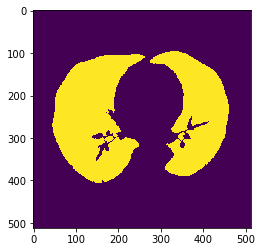

4bf6fb574a2ca2da551609e98a573e54


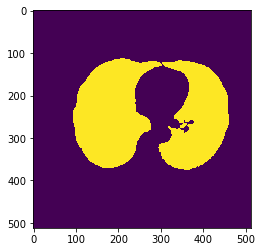

4521c94debf37a4dc9f3b70366a21640


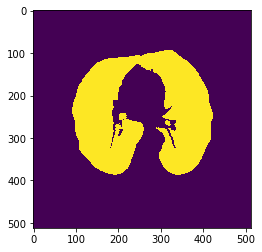

21cfe28c4a891795399bb77d63e939d7


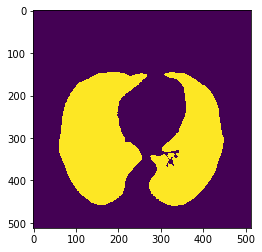

2885e3af725bc58dc1522d4bfb24bb2b


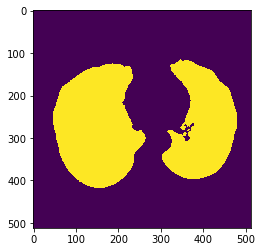

d7aa27d839b1ecb03dbf011af4bcb092


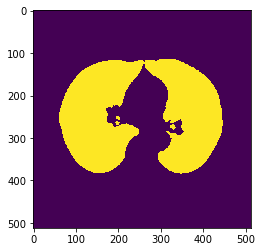

74b68f9442209bace31aa62027fbb79a


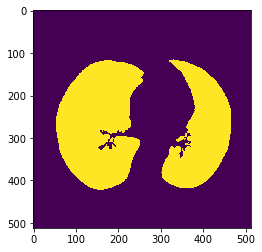

1631637f08f27347e8f23d7a0e18c100


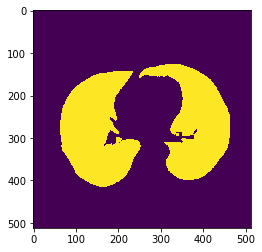

2922aac33a190fd3939de337fe3f0a34


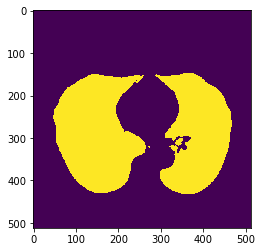

dc66d11755fd073a59743d0df6b62ee2


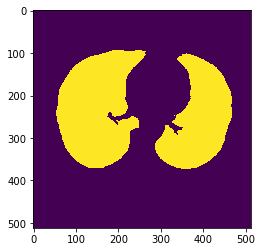

916ab7b22affc5651abfc9aae01bb355


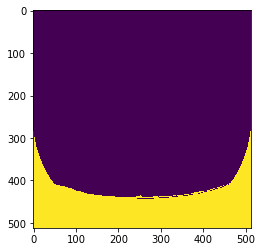

8f28d220d960b67f799479f319373c21


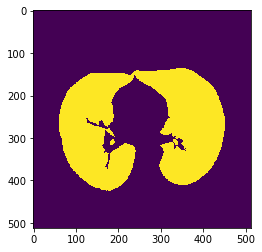

58bf189f6021ecea213c13eed7484d84


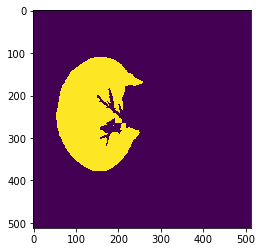

caa6c81b74054858772bda6c2a0e8ee6


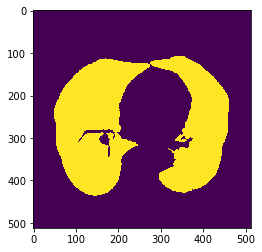

3a1a293ecad44010da9907bfc91d94cd


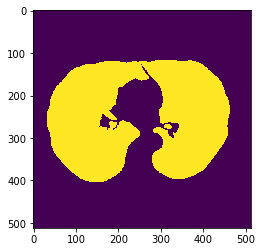

6d60c26d7d35ffd967127b380ff01c12


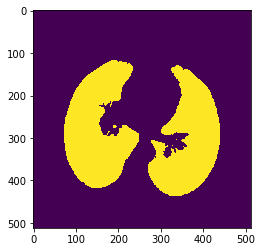

a70fd23bd8d535ffd42259cb91f4c5ca


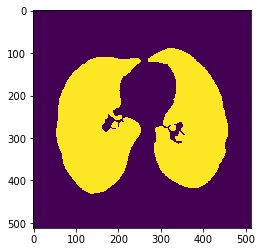

1427be78bcf4aba96c5054b697be9b5b


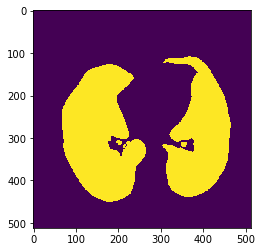

aec5a58fea38b77b964007aa6975c049


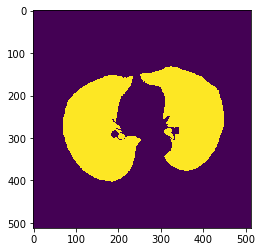

d0c86e0c3b3fe3e1dd936b7553ecc29c


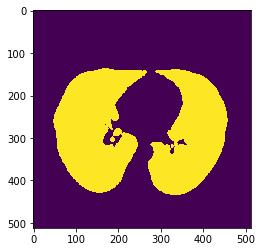

caf5e9cd994c3c90727d274dd790133a


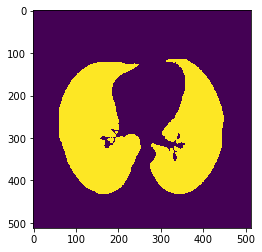

195842462645f0f331147a4c6b129a37


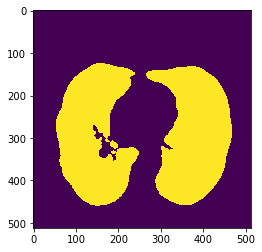

9397a41c9e819a92eb5c86e0e652d7c1


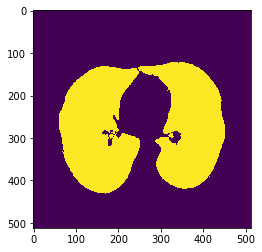

cb64ff663195832e0b66a9bb17891954


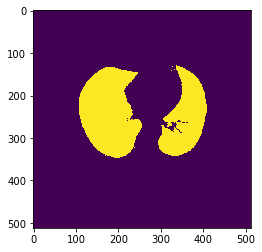

fe26fd2bb25112b3c2ca93eb8e34f8ed


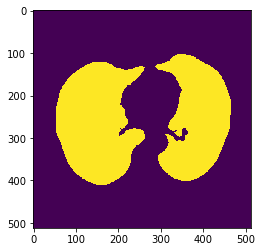

55eace190c5917cdfb390ca652149fbc


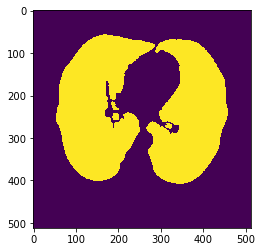

f8ecf6be8ae631c6dd694c9638a02b45


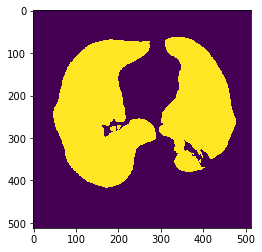

436fd6ccfc92afc44c7d3ccfe26b6129


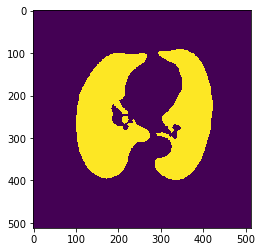

5f4e23c0f76cd00aaaa6e03744bbc362


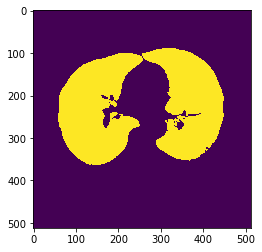

86ff28a92989348192783795a5b442e5


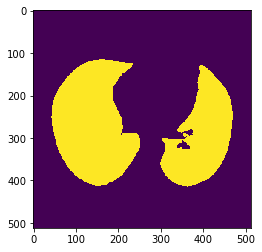

09ee522a3b7dbea48aa6d39afe240129


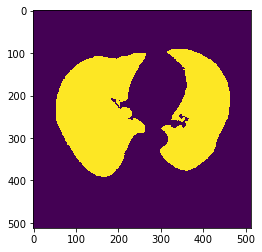

101a2999d28ce05788e6add3a28d4726


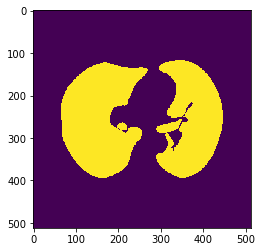

823b5f08ce145f837066d2e19dab10c1


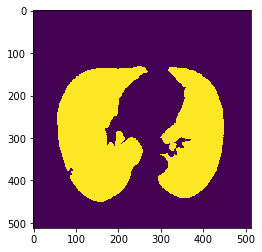

a532c6f9405e6f3a4229ea6e04b0d975


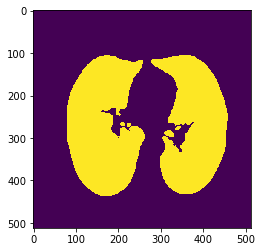

a0cdb677841933136fd15257e3c47fe6


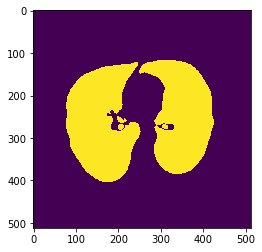

af6d573b8c6804e14e3a7b07a376e593


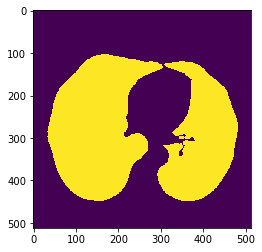

f5717f7cbc08d8bd942cd4c1128e3339


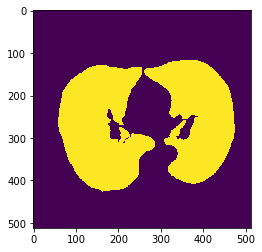

ff5d8e90500cf324e7b04a2f07cf0399


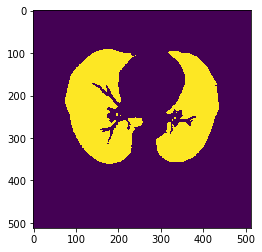

14248ec22193bed1e087755df5a28509


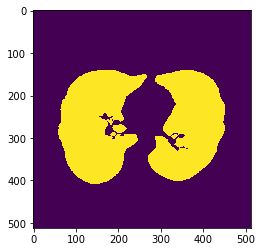

7fd5be8ec9c236c314f801384bd89c0c


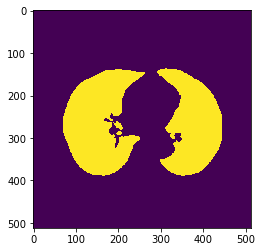

14f713c1ef037f6c531cffdff0e5fb2c


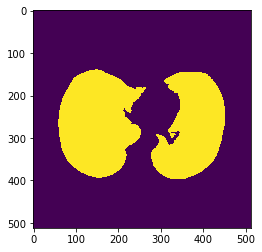

8fde44df03fb80366c6604db53d3623f


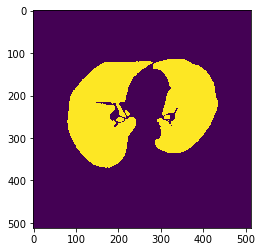

08acb3440eb23385724d006403feb585


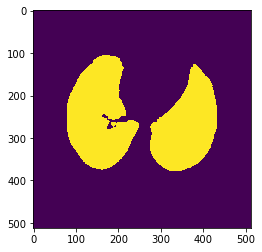

e2b7fe7fbb002029640c0e65e3051888


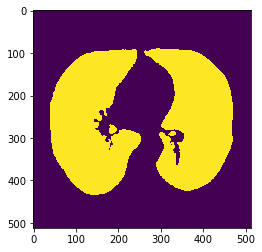

043ed6cb6054cc13804a3dca342fa4d0


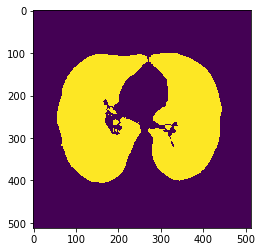

3170d41d2bc132db30399fca6bc6f376


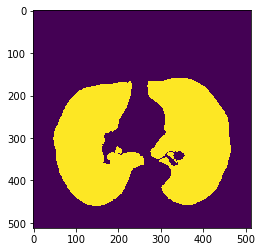

5b412509bc40a3aeb3b5efef1fdfcfc9


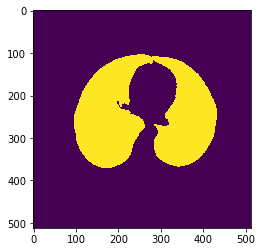

39dc5f09d7b8eeda7f2f02c86f53247d


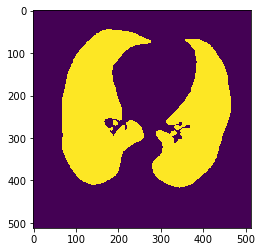

c3b05094939cc128a4593736f05eadec


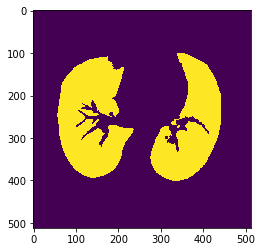

587d6230f2bad2525c47632fd792a895


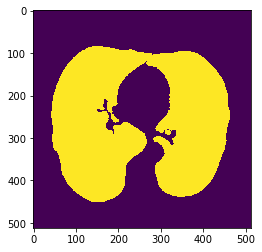

fd4c2d4738bc25a5c331dbc101f3323a


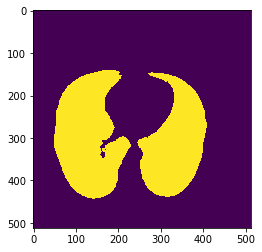

5267ea7baf6332f29163064aecf6e443


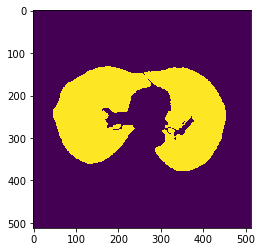

84ed26b5d79da321711ed869b3cad2ea


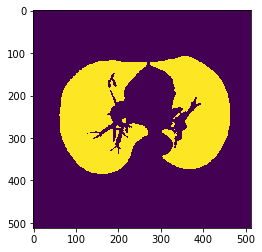

7471f583e1fb0e34d9e582c313af4358


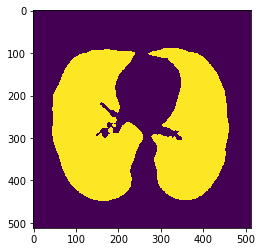

0de72529c30fe642bc60dcb75c87f6bd


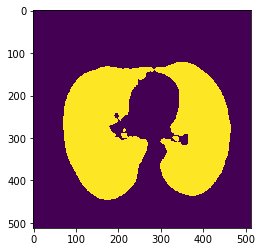

20c73e37fc89e007ae5b242480830860


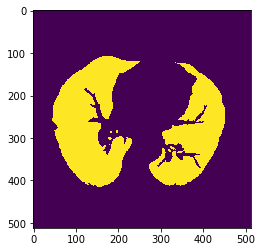

eebd87b91489548bdfc1c76a20999a54


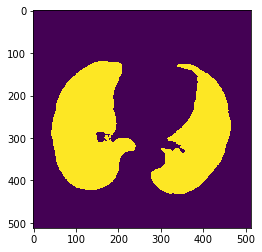

5a2e359e859d0b0d7c159fff87950852


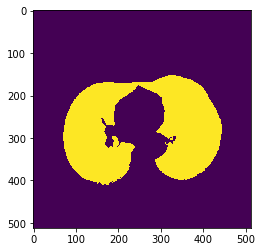

7c2fd0d32df5a2780b4b10fdf2f2cdbe


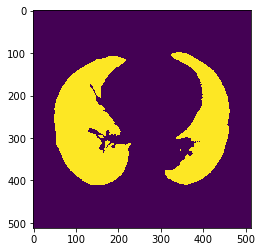

567547810a1795b9c8e11c15dfd32c34


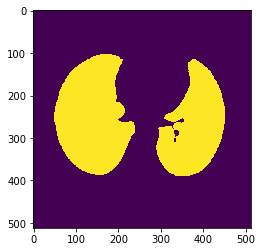

59e4e8889ae68a75227b2bd02c1d1b96


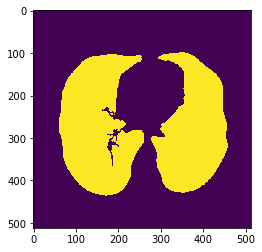

5da3dd09c0d0d597287a9a1046cced37


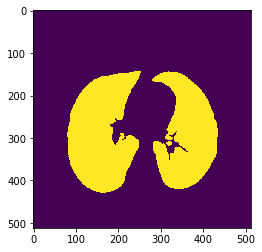

5c99ab7172afa78312fe73a3c0dd342f


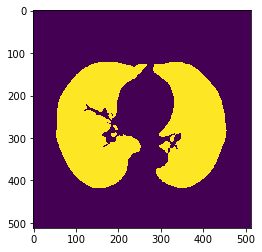

39dc5f09d7b8eeda7f2f02c86f53247d


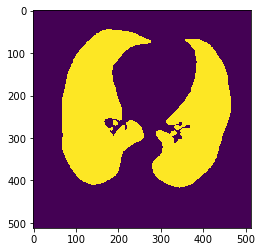

f25c425c827b35fcbaa23f2ed671540b


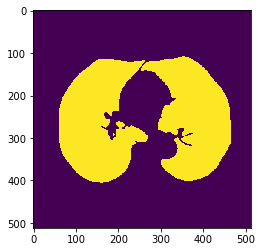

2505ca2e3cd132f69fde96ba4bb50f7b


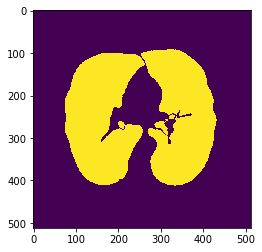

b1184cbc6dfa46734807211f95f3c998


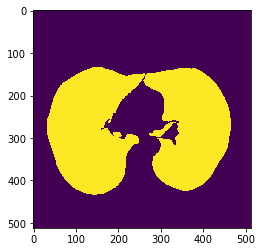

8a1fa06a0099522730dd3c12c9b9cc78


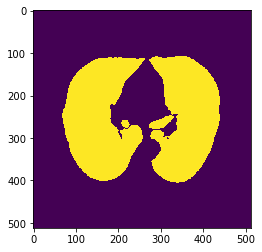

e4436b5914162ff7efea2bdfb71c19ae


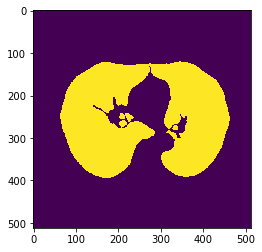

823b5f08ce145f837066d2e19dab10c1


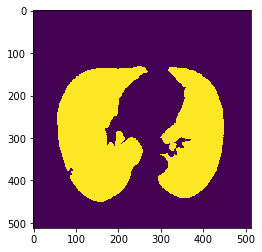

34037914ceeec5605fc890159dd425c5


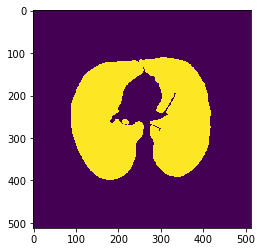

592c2481f17d6a2cecfe7bbb6a27722c


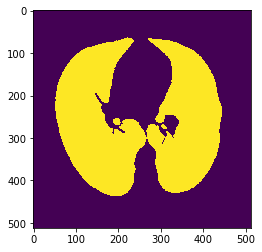

3c2dbbdeb857504a8b501fc013b99c90


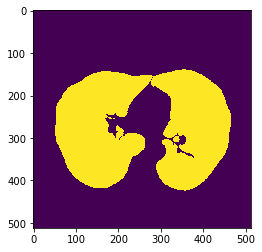

1ff6e2a80eb74396e09460c61ae69fb0


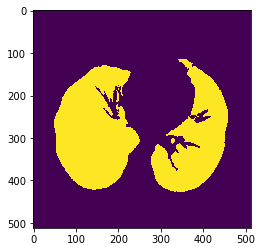

dd571c3949cdae0b59fc0542bb23e06a


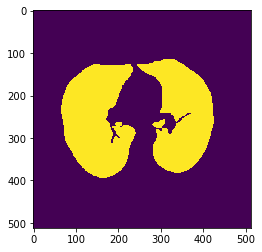

1344e604281e68ac71f25c02e7637992


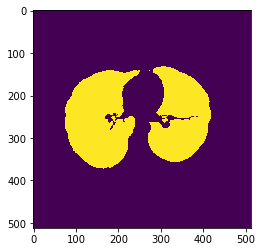

199ff05d08ade6e298d37cc542bc3565


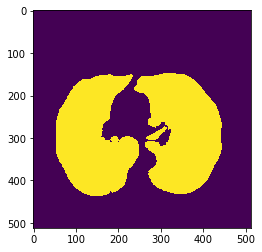

4b28f147cb82baba3edcdbd34ca19085


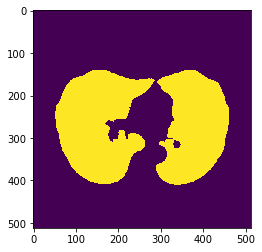

f73624b8b22774acf9a3e2c748131eac


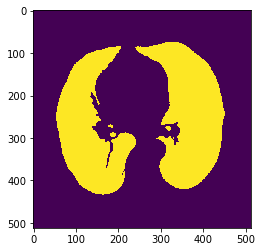

6be677ba1631174397b0c1e26a46af30


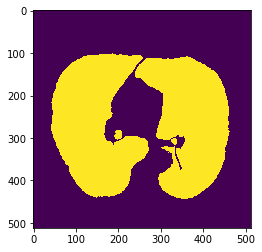

6bebfec174e8a6e8d4b1653c13fcdbe5


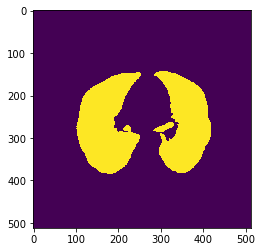

d2282b0eb61b8d3b090cf8eb76776529


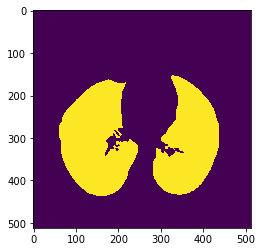

cc31a959bf4c2a6de3a67dfa378a261c


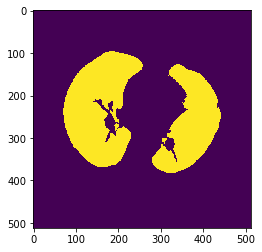

b51f22a84cd2fae1de8bd1eb155933f7


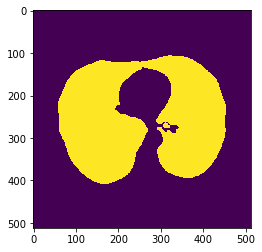

448ce51772879fcd88f61c07b06347b2


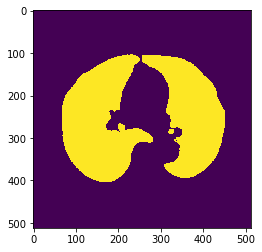

ca4e1486c548679a9c682b6fa1a779d9


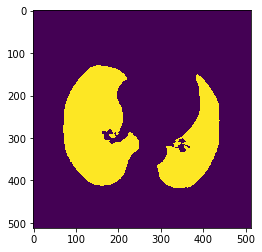

87b81bd007c5b23cd0c0aeca722fe52f


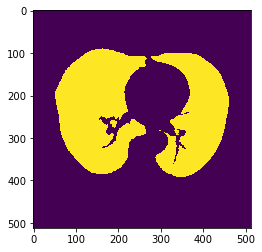

67f7f74220c08faa756b34cb81b203a5


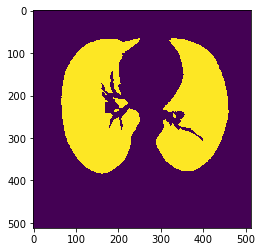

c31e3540b227a1a2b08593094609ece2


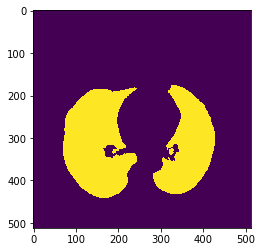

4d86e1657d46b9ee44c2c434fad231ce


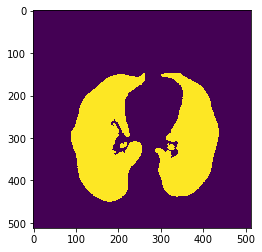

fb7dfb6aae597d97c2da24179df0fe56


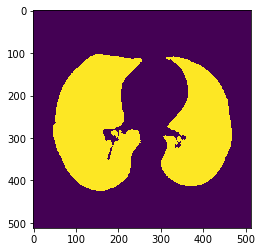

In [110]:
for pid in range(100): # bad_pids:
    pid = random.choice(patient_ids)
    print(pid)
    image = np.load(OUTPUT_FOLDER + 'segmented_lungs/' + pid + '.npy')
    
    # reprocess here
#     image = np.load(OUTPUT_FOLDER + 'original_resolution/' + pid + '.npy')
#     binary_image = np.array(image > -320, dtype=np.int8)
#     binary_image = scipy.ndimage.morphology.binary_dilation(binary_image, border_value=0, iterations=2).astype(np.int8)
#     # HACK deal with trays
#     binary_image[-1,:,0] = 0
#     binary_image[-1,:,-1] = 0
#     binary_image += 1
#     labels = measure.label(binary_image)
#     plt.imshow(labels[:,:,128] == labels[0,0,0])

    #plt.imshow(image[:,256,:])
    plt.imshow(image[int(image.shape[0]//2),:,:])
    plt.show()

In [51]:
bad_ids = ['09b1c678fc1009d84a038cd879be4198',
'0acbebb8d463b4b9ca88cf38431aac69',
'11f10c2a0bfd231deeec98d69e4d0767',
'2a2300103f80aadbfac57516d9a95365',
'39c3a2d2ca67bc7a1a22240ea571d50c',
'40c044145f5c87c12bd8c725924add3c',
'50cdacec399071cf70d8badd2511d0b3',
'5c0d992d01e6383d5684b8ac5d7143b1',
'718f43ecf121c79899caba1e528bd43e',
'78459ff46c9f3b3fa26be2a467515c7e',
'820245d8b211808bd18e78ff5be16fdb',
'95a27273c11db8bfb9fc27b1e64de6bd',
'a2d9e657a673798f9ebdfec1b361f93a',
'b7ef0e864365220b8c8bfb153012d09a',
'b8276dbece0182602d2ae0c825dfa1b4',
'c3b05094939cc128a4593736f05eadec',
'c5f73cf44d785e5ac2e7f0a8897f683c',
'cbf5f53f3648de7d1324257caa40bb90',
'cca8f8cc51b58df2a4804a7aee8eef8c',
'cf0a772e90a14d77d664ce9baedf0e5c',
'd1a20ef45bb03f93a407b492066f6d88',
'd8a0ebe575539c2357c2365cdf0229a0',
'f7cdd95c94818875ece1175561025038',
'fcfab3eddbdf0421c39f71d651cc5c56']


In [101]:
bad_pids = []
for pid in patient_ids:
#     print(pid)
    image = np.load(OUTPUT_FOLDER + 'segmented_lungs/' + pid + '.npy')
    if np.amax(image[:,256,:]) == 0:
        print("bad " + pid)
        bad_pids.append(pid)

bad 2969c7ad0e550fee1f4a68fcb3bbb9e5
bad 402a18fa05523f80abb1e6d97793cc19
bad ca3cdb2e771df9989df5a9cb0296c44c
bad cf0a772e90a14d77d664ce9baedf0e5c
bad edad1a7e85b5443e0ae9e654d2adbcba
bad f1a64fda219db48bcfb8ad3823ef9fc1


In [97]:
len(bad_pids)

164